In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
from lmoments3 import distr

from modules.api import load_config, extract_regions, extract_coloc 
from modules.api import corrmatrix, samlmomgev, Simulation

In [2]:
# Load parameters from config file
config = load_config(Path('config.json'))
dir_root = config['dir_root']
region_file = config['region_file']
prism_file = config['prism_file']
meta_file = config['meta_file']
coloc_file = config['coloc_file']
ARI = np.array(config['ARI']) # Average Recurrence Interval
aep = 1 - 1/ARI  # Annual Exceedance Probability
base_durations = config['base_durations']
prism_durations = config['prism_durations']
nsim = config['nsim'] # Number of Monte Carlo Simulations
boundprob = config['boundprob'] # 90% CI
nmom = config['nmom'] # number of L-moments

#### Read metadata and Co-locations

In [3]:
df_meta = pd.read_parquet(Path(meta_file), engine='pyarrow')
coloc = extract_coloc(coloc_file)

#### Read PRISM MAM

In [4]:
prism_mam_df = pd.read_csv(Path(prism_file), sep = '\s+')
prism_mam_df = prism_mam_df.rename(columns={'Site_ID': 'HDSC'}).set_index('HDSC', drop=True)

#### Read regionalization data

In [5]:
sids, regions = extract_regions(Path(region_file))

#### Subset ID, WY, and MT stations and exclude the buffer stations

In [6]:
# sids = coloc[(coloc['HDSC_ID'].isin(sids)) & (coloc['ST'].isin(['ID', 'WY', 'MT']))]['HDSC_ID'].unique()
df_meta1 = pd.concat([df_meta[df_meta['HDSC'] == sid] for sid in sids])
lat = df_meta1['LAT'].values
lon = df_meta1['LON'].values

#### Enter Reference station, base duration, and prism duration from the below list

base_durations: ["60m", "06h", "24h", "04d", "10d", "30d", "60d"]  

prism_durations: ["60min", "6hr", "24hr", "4day", "10day", "30day", "60day"]

In [7]:
base = '60m'
prism_duration = '60min'
sid = '86-1045' #sids[30]

#### Read AMS and PRISM MAM for all the sites in a region

In [8]:
ams_df = pd.read_parquet(Path(dir_root, f'df_ams_{base}.parquet.snappy'), engine='pyarrow')
ams_df = ams_df.join(df_meta['HDSC'])
ams_df = ams_df.set_index('HDSC', drop=True)
sid_region = [sid] + regions[sid]
# Extract AMS for all stations in a region
ams = ams_df[ams_df.index.isin(sid_region)].copy()
# Get PRISM MAM
mam_prism = prism_mam_df[prism_mam_df.index.isin(sid_region)][prism_duration].copy()

#### Calculate the at-site L-moments and GEV parameters

In [9]:
lmoms, paras = samlmomgev(ams, mam_prism)

In [10]:
lmoms

,n,mean,l1,l2,t,t3,t4,t5
HDSC,,,,,,,,
57-0017,23,0.8724,0.870100,0.199782,0.229608,0.062183,0.066845,-0.048446
79-0018,75,0.9217,0.925847,0.250412,0.270468,0.280239,0.231072,0.167051
79-0021,57,0.6059,0.605244,0.159269,0.263149,0.196653,0.142432,0.046517
86-0322,22,0.5445,0.436591,0.085361,0.195518,0.273352,0.113558,-0.118082
86-0718,17,0.5031,0.498529,0.122140,0.245000,0.417687,0.289601,0.107797
86-1045,16,0.6276,0.565000,0.117708,0.208333,0.109714,0.117363,-0.101978


#### Average inter-site correleation coefficient.
##### This is used to create a synthetic correleated AMS for the sites to be used in Monte Carlo Simulations

In [11]:
rho, sd_rho = corrmatrix(ams)
print(f'Average inter-site correleation coefficient: {rho}')
print(f'Standard deviation of rho: {sd_rho}')

Average inter-site correleation coefficient: 0.1640856169770485
Standard error of rho: 0.1265161974443776


#### Run Monte Carlo Simulation

In [12]:
smam = mam_prism.loc[sid]
if np.isnan(smam):
    if sid not in lmoms.index:
        print(f'No MAM for {sid} at {base} duration. Therefore do not proceed further.')
    else:
        smam = lmoms.loc[sid]['mean']
print(f'Reference Station MAM: {smam}')

Reference Station MAM: 0.6276


In [13]:
distributions = [distr.gev, distr.gno, distr.glo, distr.pe3] 

In [14]:
sim = Simulation(sid, base, rho, sd_rho, ARI, lmoms, smam, nsim, distributions, boundprob)
sim.run_simulations()
quantile, lbound, ubound = sim.bounds()

In [15]:
lbound, quantile, ubound

(array([0.51958987, 0.93864554, 1.17490432, 1.55046104]),
 array([0.63526466, 1.25414889, 1.66857299, 2.48005542]),
 array([0.77518994, 1.62936164, 2.27832165, 3.97462133]))

In [16]:
lbound/quantile, ubound/quantile

(array([0.81791086, 0.7484323 , 0.70413721, 0.62517193]),
 array([1.22026297, 1.2991772 , 1.36543122, 1.60263408]))

<Figure size 640x480 with 0 Axes>

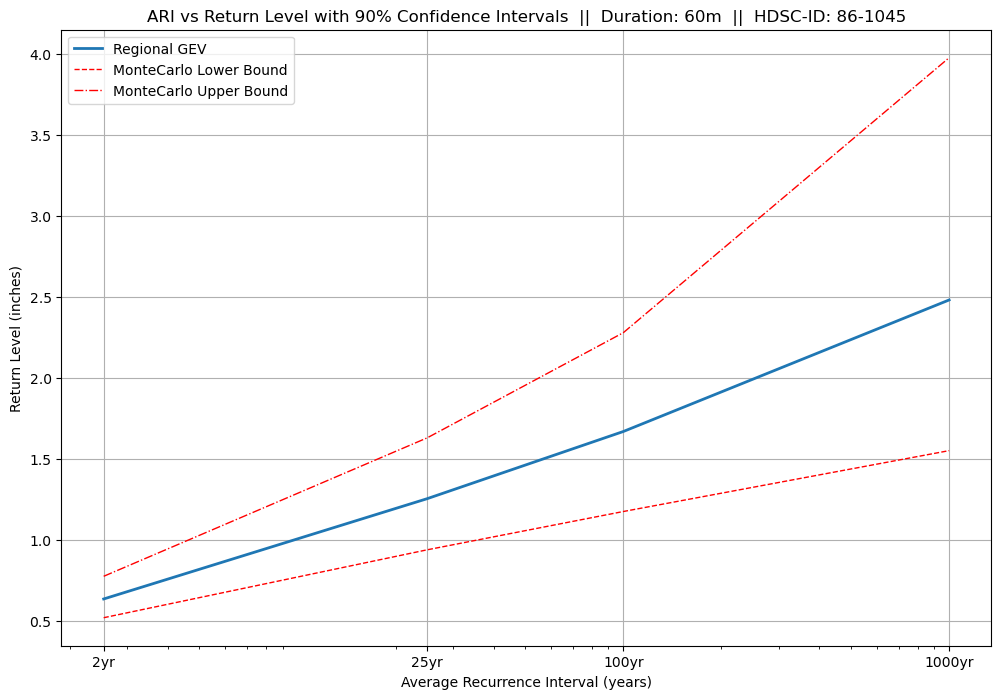

In [17]:
# Plotting
fig = plt.gcf()
plt.figure(figsize=(12, 8))
plt.plot(ARI, quantile, linewidth=2, label='Regional GEV')
plt.plot(ARI, lbound, '--', color='red', linewidth=1, label='MonteCarlo Lower Bound')
plt.plot(ARI, ubound, '-.', color='red', linewidth=1, label='MonteCarlo Upper Bound')
plt.xscale('log')
plt.xticks(ARI, ['2yr', '25yr', '100yr', '1000yr'], rotation=0);
plt.xlabel('Average Recurrence Interval (years)')
plt.ylabel('Return Level (inches)')
plt.title(f'ARI vs Return Level with 90% Confidence Intervals  ||  Duration: {base}  ||  HDSC-ID: {sid}')
plt.legend()
plt.grid(True)
fig.subplots_adjust(right=0.85)  

<Figure size 640x480 with 0 Axes>

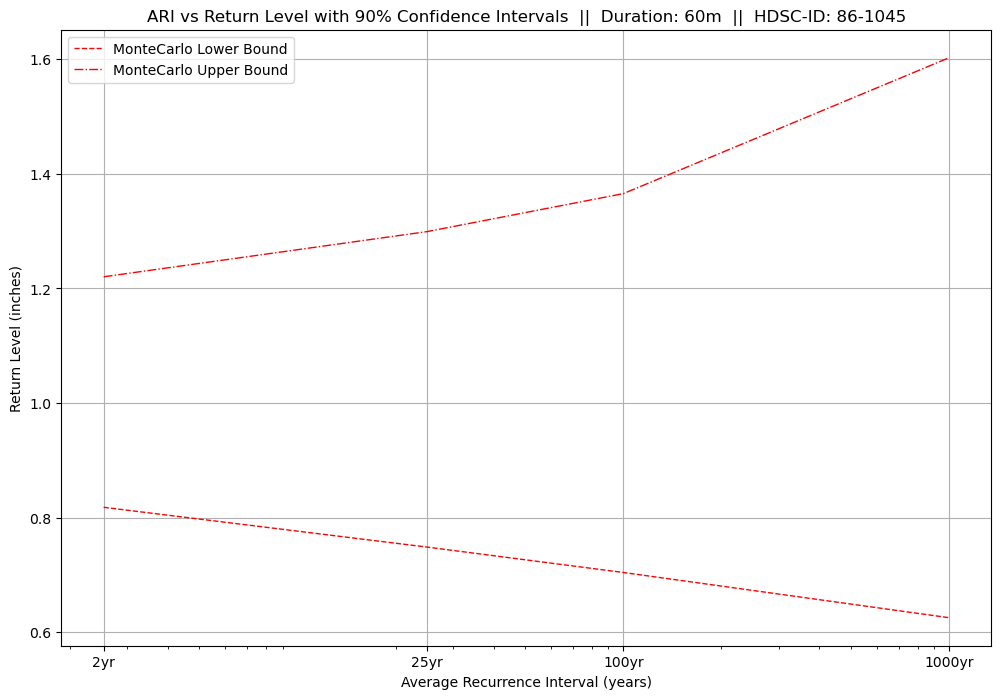

In [18]:
# Plotting
fig = plt.gcf()
plt.figure(figsize=(12, 8))
# plt.plot(ARI, quantile, linewidth=2, label='Regional GEV')
plt.plot(ARI, lbound/quantile, '--', color='red', linewidth=1, label='MonteCarlo Lower Bound')
plt.plot(ARI, ubound/quantile, '-.', color='red', linewidth=1, label='MonteCarlo Upper Bound')
plt.xscale('log')
plt.xticks(ARI, ['2yr', '25yr', '100yr', '1000yr'], rotation=0);
plt.xlabel('Average Recurrence Interval (years)')
plt.ylabel('Return Level (inches)')
plt.title(f'ARI vs Return Level with 90% Confidence Intervals  ||  Duration: {base}  ||  HDSC-ID: {sid}')
plt.legend()
plt.grid(True)
fig.subplots_adjust(right=0.85)  